# LSTM Stock Predictor Using Closing Prices

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin closing prices to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [81]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [82]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [83]:
# Load the historical closing prices for Bitcoin
df = pd.read_csv('Resources/BTC_USD_2013-10-01_2020-12-29-CoinDesk.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [84]:
# # Append days in the future
# from datetime import datetime
# from datetime import timedelta

# current_day = pd.to_datetime( datetime.now().strftime("%Y-%m-%d") )
# num_days = 20

# for i in range(1, num_days + 1):
#     df.loc[current_day + timedelta(days=i)] = ["BTC", 0, 0, 0, 0]

# df.tail()

In [86]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
#     for i in range(len(df) - window - 1):
    for i in range(len(df) - window):
        features = df.iloc[i:(i + window), feature_col_number]
            # max i = 2637 - 10 - 1    - 1 = 2625
            # i:(i + window) for maxi =  2625:(2635)      (len(df) == 2637)
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [133]:
# [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# (10-2+1) - (2-1)

# 10-2
# 8

def append_window_data(df, num_trailing_windows, window_length, feature_col_number, target_col_number):
    X = []
    y = []

    i_start = len(df) - window_length - num_trailing_windows
    i_end = i_start + num_trailing_windows
    
#     print(f"i_start {i_start}  i_end {i_end}")
    
    for i in range(i_start, i_end):

#         print(f"i {i}")
        
#         print(f"features range: {[i, (i + window_length)]}")
        features = df.iloc[i:(i + window_length), feature_col_number]
#         print(f"target range: {[i + window_length]}")
        target = df.iloc[i + window_length, target_col_number]
        
#         print(f"features {features}")
#         print(f"target {target}")
        
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)


In [134]:
df.tail(20)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2020-12-10,BTC,18359.476600,18557.452909,18565.216167,17904.068986
2020-12-11,BTC,18137.319375,18255.773754,18293.552732,17593.172099
2020-12-12,BTC,18882.260171,18040.170620,18956.344444,18029.143166
2020-12-13,BTC,19060.276901,18822.509939,19408.674653,18726.847085
2020-12-14,BTC,19251.224005,19161.138466,19323.165315,19015.685970
2020-12-15,BTC,19443.476353,19264.670301,19552.371978,19053.342472
2020-12-16,BTC,21310.656262,19433.141368,21447.523852,19293.298961
2020-12-17,BTC,22895.976238,21351.254809,23770.846569,21248.365335
2020-12-18,BTC,23008.776257,22819.558896,23261.252880,22357.607647


In [135]:
append_window_data(df, num_trailing_windows=1, window_length=2, feature_col_number=1, target_col_number=1)

(array([[26389.29026494, 26718.0294634 ]]), array([[26975.72956452]]))

In [136]:
append_window_data(df, num_trailing_windows=4, window_length=2, feature_col_number=1, target_col_number=1)

(array([[23623.88553323, 24581.00617127],
        [24581.00617127, 26381.29623292],
        [26381.29623292, 26389.29026494],
        [26389.29026494, 26718.0294634 ]]),
 array([[26381.29623292],
        [26389.29026494],
        [26718.0294634 ],
        [26975.72956452]]))

In [137]:
append_window_data(df, num_trailing_windows=1, window_length=3, feature_col_number=1, target_col_number=1)

(array([[26381.29623292, 26389.29026494, 26718.0294634 ]]),
 array([[26975.72956452]]))

In [138]:
append_window_data(df, num_trailing_windows=4, window_length=3, feature_col_number=1, target_col_number=1)

(array([[23224.45413785, 23623.88553323, 24581.00617127],
        [23623.88553323, 24581.00617127, 26381.29623292],
        [24581.00617127, 26381.29623292, 26389.29026494],
        [26381.29623292, 26389.29026494, 26718.0294634 ]]),
 array([[26381.29623292],
        [26389.29026494],
        [26718.0294634 ],
        [26975.72956452]]))

In [ ]:
# def window_data(df, sequence_start, sequence_length, window, feature_col_number, target_col_number):
#     X = []
#     y = []
#     for i in range(sequence_start, sequence_length - window):
#         features = df.iloc[i:(i + window), feature_col_number]
#         target = df.iloc[(i + window), target_col_number]
#         X.append(features)
#         y.append(target)
#     return np.array(X), np.array(y).reshape(-1, 1)

In [87]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [88]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

In [89]:
df.tail(10)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2020-12-20,BTC,23537.369891,23829.284804,24273.041505,23085.954770
2020-12-21,BTC,23177.270998,23476.087500,24081.053094,21960.191348
2020-12-22,BTC,23433.980758,22729.659291,23629.404460,22384.127846
2020-12-23,BTC,23224.454138,23791.565294,24086.950661,22644.561058
2020-12-24,BTC,23623.885533,23228.909087,23737.757149,22716.174167
2020-12-25,BTC,24581.006171,23726.190999,24627.297914,23422.310325
2020-12-26,BTC,26381.296233,24708.206784,26750.879954,24497.410869
2020-12-27,BTC,26389.290265,26447.708072,28352.627824,25759.068609
2020-12-28,BTC,26718.029463,26226.066130,27447.551384,26046.625578


In [90]:
X_test[X_test.shape[0]-1]

array([23890.82264887, 23537.36989089, 23177.27099799, 23433.98075814,
       23224.45413785, 23623.88553323, 24581.00617127, 26381.29623292,
       26389.29026494, 26718.0294634 ])

In [51]:
X[:split]

array([[ 123.65499   ,  125.455     ,  108.58483   , ...,  123.033     ,
         124.049     ,  125.96116   ],
       [ 125.455     ,  108.58483   ,  118.67466   , ...,  124.049     ,
         125.96116   ,  125.27966   ],
       [ 108.58483   ,  118.67466   ,  121.33866   , ...,  125.96116   ,
         125.27966   ,  125.9275    ],
       ...,
       [6321.71367131, 6341.09481265, 6360.14127192, ..., 6514.48945274,
        6412.52428906, 6343.63250376],
       [6341.09481265, 6360.14127192, 6344.73894294, ..., 6412.52428906,
        6343.63250376, 6365.65523152],
       [6360.14127192, 6344.73894294, 6405.13975468, ..., 6343.63250376,
        6365.65523152, 6327.4806461 ]])

In [52]:
X[split:]

array([[6344.73894294, 6405.13975468, 6396.35212354, ..., 6365.65523152,
        6327.4806461 , 6327.15469606],
       [6405.13975468, 6396.35212354, 6425.91780182, ..., 6327.4806461 ,
        6327.15469606, 6282.43867716],
       [6396.35212354, 6425.91780182, 6514.48945274, ..., 6327.15469606,
        6282.43867716, 5524.80109342],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

In [33]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.

scaler = MinMaxScaler()
scaler.fit(X_train)
# scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [34]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[7.90736096e-04]
  [8.85183194e-04]
  [0.00000000e+00]
  [0.00000000e+00]
  [3.58772654e-05]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [3.57898734e-05]]

 [[8.85183194e-04]
  [0.00000000e+00]
  [5.29416594e-04]
  [1.39854970e-04]
  [0.00000000e+00]
  [5.98367452e-05]
  [6.50033109e-05]
  [5.33502885e-05]
  [1.00413121e-04]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [5.29416594e-04]
  [6.69197523e-04]
  [1.03981435e-04]
  [5.98367452e-05]
  [1.24836166e-04]
  [1.18350131e-04]
  [1.53758052e-04]
  [6.46255601e-05]
  [3.40221740e-05]]

 [[5.29416594e-04]
  [6.69197523e-04]
  [6.33342980e-04]
  [1.63811959e-04]
  [1.24836166e-04]
  [1.78179795e-04]
  [2.18751368e-04]
  [1.17972401e-04]
  [9.86455354e-05]
  [5.79606891e-05]]

 [[6.69197523e-04]
  [6.33342980e-04]
  [6.93141828e-04]
  [2.28804621e-04]
  [1.78179795e-04]
  [2.78575024e-04]
  [1.82968043e-04]
  [1.51990561e-04]
  [1.22582503e-04]
  [5.23184930e-04]]] 

X_test sample v

---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:

1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [36]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))


In [37]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [38]:
# Summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 5)             140       
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 5)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 5)             220       
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 5)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_8 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [39]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
1852/1852 [==============================] - 10s 5ms/step - loss: 7.1956e-04
Epoch 2/10
1852/1852 [==============================] - 10s 5ms/step - loss: 0.0015
Epoch 3/10
1852/1852 [==============================] - 10s 6ms/step - loss: 0.0016
Epoch 4/10
1852/1852 [==============================] - 10s 6ms/step - loss: 0.0019
Epoch 5/10
1852/1852 [==============================] - 10s 5ms/step - loss: 0.0016
Epoch 6/10
1852/1852 [==============================] - 10s 6ms/step - loss: 0.0017
Epoch 7/10
1852/1852 [==============================] - 10s 6ms/step - loss: 0.0019
Epoch 8/10
1852/1852 [==============================] - 10s 6ms/step - loss: 0.0019
Epoch 9/10
1852/1852 [==============================] - 10s 5ms/step - loss: 0.0019
Epoch 10/10
1852/1852 [==============================] - 10s 5ms/step - loss: 0.0018


---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [40]:
# Evaluate the model
model.evaluate(X_test, y_test)

25/25 [==============================] - 0s 3ms/step - loss: 0.0319


0.03188763186335564

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-01-18,BTC,0.0,0.0,0.0,0.0


In [41]:
# Loop to build each day's prediction.
predicted = model.predict(X_test)

current_day = pd.to_datetime( datetime.now().strftime("%Y-%m-%d") )
num_days = 20

for i inrange(1, num_days + 1):





# # Append days in the future
# from datetime import datetime
# from datetime import timedelta

# current_day = pd.to_datetime( datetime.now().strftime("%Y-%m-%d") )
# num_days = 20

# for i in range(1, num_days + 1):
#     df.loc[current_day + timedelta(days=i)] = ["BTC", 0, 0, 0, 0]

# df.tail()


In [42]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [43]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2018-11-14,6282.438677,6323.466309
2018-11-15,5524.801093,6323.500000
2018-11-16,5511.152834,6323.702637
2018-11-17,5448.600634,6324.264648
2018-11-18,5497.411279,6325.189941


<AxesSubplot:xlabel='Date'>

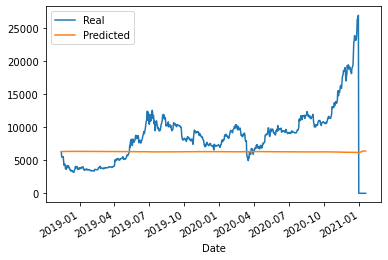

In [44]:
# Plot the real vs predicted values as a line chart
stocks.plot()